# Cisc Issuer Analysis

In [3]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import os
from tldextract import extract
from pandas.core.frame import DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.functions import StringType
import matplotlib.pyplot as plt

In [4]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [5]:
SQLContext = SparkSession.builder.master("local[1]") \
                .appName("session-0") \
                .getOrCreate()

22/12/02 13:48:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
ssl_df = SQLContext.read.parquet("/mnt/chaseproject/uva/kd5eyn/ssl/2022-04-01/anon.ssl_20220401_0000-0030-0400.log.gz")

KeyboardInterrupt: 

In [6]:
x509_df = SQLContext.read.parquet("/mnt/chaseproject/uva/kd5eyn/x509/2022-04-01/anon.x509_20220401_0000-0030-0400.log.gz")

# SSL and X509 DF Data Exploration

In [16]:
def get_issuer_org(issuer_str: str):
    if type(issuer_str) == str:
        o_index = issuer_str.find("O=")
        comma_index = issuer_str.find(",", o_index)
        #Get characters starting from after O= and before ,
        org_str = issuer_str[o_index + 2 :comma_index]
        return org_str.replace("\\", "")

def get_domain(server_name_str: str):
    if type(server_name_str) == str:
        url_parts = extract(server_name_str)
        subdomain = url_parts.subdomain
        domain = url_parts.domain
        #tld - top level domain
        tld = url_parts.suffix
        
        return f"{subdomain}.{domain}.{tld}"

In [4]:
issuer_org_udf = udf(lambda issuer_str: get_issuer_org(issuer_str), StringType())
domain_udf = udf(lambda server_name: get_domain(server_name), StringType())
ssl_df = ssl_df.withColumn("issuer_O", issuer_org_udf(col("issuer")))
ssl_df = ssl_df.withColumn("domain", domain_udf(col("server_name")))

NameError: name 'ssl_df' is not defined

In [ ]:
cisc_ssl_df = ssl_df.filter(ssl_df.issuer_O == "CISC")

In [ ]:
cisc_ssl_df.count()

0

In [5]:
import os
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.functions import lit

In [6]:
def get_issuer_df(df: DataFrame):
        issuer_org_udf = udf(lambda issuer_str: get_issuer_org(issuer_str), StringType())
        domain_udf = udf(lambda server_name: get_domain(server_name), StringType())
        df = df.withColumn("issuer_O", issuer_org_udf(col("issuer")))
        df = df.withColumn("domain", domain_udf(col("server_name")))
        return df

In [7]:
def filter_issuer_df(df: DataFrame, issuer_O: str, filename: str) -> DataFrame:
    df = get_issuer_df(df)
    df = df.filter(df.issuer_O == issuer_O)
    df = df.withColumn("file", lit(filename))
    return df

In [9]:
def combine_issuer_dfs(spark_session: SparkSession, dir_str: str, issuer_O: str) -> DataFrame:
    parquet_files = os.listdir(dir_str)
    combined_df = spark_session.read.parquet(dir_str + parquet_files[0])
    combined_df = filter_issuer_df(combined_df, issuer_O, parquet_files[0])
    
    for parquet in parquet_files[1:]:
        df = spark_session.read.parquet(dir_str + parquet)
        df = filter_issuer_df(df, issuer_O, parquet)
        if df.count() > 0:
            combined_df.union(df)
    return combined_df

In [17]:
data_path = "/mnt/chaseproject/uva/kd5eyn/ssl/2022-04-02/"
df = combine_issuer_dfs(SQLContext, data_path, "Cisc")

In [18]:
df.write.parquet("Cisc-2022-04-02.parquet")

In [ ]:
print(df.count())

206


In [ ]:
import pyspark
#saved_df = SQLContext.read.parquet("Cisc.parquet")


In [ ]:
df.toPandas()

,_lpp_ver,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,client_subject,curve,established,...,resumed,server_name,subject,ts,uid,validation_status,version,issuer_O,domain,file
0,1.11-7,uva,none,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:30:22.341141Z,CVESXx3EZ4TLDTxyxf,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
1,1.11-7,uva,none,"[FnYwuq2cmQ3VCeGtug, Fibeb8v0Zc0vL9nli, FkY1Uu...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,outlook.office365.com,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",2022-04-01T05:30:32.068036Z,CvyYcD1TlamjejMwoa,unable to get local issuer certificate,TLSv12,Cisc,outlook.office365.com,anon.ssl_20220401_0130-0200-0400.log.gz
2,1.11-7,uva,none,"[FfPe7a1bMBfzmLxeHc, Fs0MZ3Sdz7m2nFKG3, Fudo7Z...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,autodiscover-s.outlook.com,"CN=autodiscover-s.outlook.com,O=OpenDNS\, Inc....",2022-04-01T05:30:40.516649Z,CVtKvb2nydVNDocYJ,unable to get local issuer certificate,TLSv12,Cisc,autodiscover-s.outlook.com,anon.ssl_20220401_0130-0200-0400.log.gz
3,1.11-7,uva,none,"[FsjdYB19ZRz1yRuH07, F2RAfA2B6Pc9EW9YOa, FnFyw...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:30:53.556438Z,CTZZcd1BbAQXvBfqw,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
4,1.11-7,uva,none,"[Feykld2hcC9Vqqfci2, FcPGaE2usoyzyTgDt1, Fyiea...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,go.trouter.teams.microsoft.com,"CN=go.trouter.teams.microsoft.com,O=OpenDNS\, ...",2022-04-01T05:30:57.047217Z,CRqhUi4UijMSM21Djg,unable to get local issuer certificate,TLSv12,Cisc,go.trouter.teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,1.11-7,uva,none,"[F50Seo2ePy9duIVwU6, FUFo5SK2eafi6lLIg, FSF1bC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,outlook.office365.com,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",2022-04-01T05:58:48.654677Z,C5j1JS3FKq4K6ICrm1,unable to get local issuer certificate,TLSv12,Cisc,outlook.office365.com,anon.ssl_20220401_0130-0200-0400.log.gz
202,1.11-7,uva,none,"[Fi6cIT2qqVOOIROKX4, F4VncpAjZIyqpqC79, Fg2iDH...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:58:53.562728Z,Cn8QjsGPPEV7av5P8,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
203,1.11-7,uva,none,"[F2EiNv4v1bQmKFJaz7, F5oQsw2OtobkMXXkK2, FafPC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,go.trouter.teams.microsoft.com,"CN=go.trouter.teams.microsoft.com,O=OpenDNS\, ...",2022-04-01T05:59:14.502378Z,CBuhZE2jWqH4i700Ee,unable to get local issuer certificate,TLSv12,Cisc,go.trouter.teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
204,1.11-7,uva,none,"[F0lPmq2O9Pp97ZPkE5, Fothvo3IilNo8arfX8, Fhgid...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:59:14.949941Z,CsGrt32k4GeMhm1iE6,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz


In [ ]:
df = pd.read_parquet("Cisc2.parquet")
df

,_lpp_ver,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,client_subject,curve,established,...,resumed,server_name,subject,ts,uid,validation_status,version,issuer_O,domain,file
0,1.11-7,uva,none,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:30:22.341141Z,CVESXx3EZ4TLDTxyxf,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
1,1.11-7,uva,none,"[FnYwuq2cmQ3VCeGtug, Fibeb8v0Zc0vL9nli, FkY1Uu...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,outlook.office365.com,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",2022-04-01T05:30:32.068036Z,CvyYcD1TlamjejMwoa,unable to get local issuer certificate,TLSv12,Cisc,outlook.office365.com,anon.ssl_20220401_0130-0200-0400.log.gz
2,1.11-7,uva,none,"[FfPe7a1bMBfzmLxeHc, Fs0MZ3Sdz7m2nFKG3, Fudo7Z...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,autodiscover-s.outlook.com,"CN=autodiscover-s.outlook.com,O=OpenDNS\, Inc....",2022-04-01T05:30:40.516649Z,CVtKvb2nydVNDocYJ,unable to get local issuer certificate,TLSv12,Cisc,autodiscover-s.outlook.com,anon.ssl_20220401_0130-0200-0400.log.gz
3,1.11-7,uva,none,"[FsjdYB19ZRz1yRuH07, F2RAfA2B6Pc9EW9YOa, FnFyw...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:30:53.556438Z,CTZZcd1BbAQXvBfqw,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
4,1.11-7,uva,none,"[Feykld2hcC9Vqqfci2, FcPGaE2usoyzyTgDt1, Fyiea...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,go.trouter.teams.microsoft.com,"CN=go.trouter.teams.microsoft.com,O=OpenDNS\, ...",2022-04-01T05:30:57.047217Z,CRqhUi4UijMSM21Djg,unable to get local issuer certificate,TLSv12,Cisc,go.trouter.teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,1.11-7,uva,none,"[F50Seo2ePy9duIVwU6, FUFo5SK2eafi6lLIg, FSF1bC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,outlook.office365.com,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",2022-04-01T05:58:48.654677Z,C5j1JS3FKq4K6ICrm1,unable to get local issuer certificate,TLSv12,Cisc,outlook.office365.com,anon.ssl_20220401_0130-0200-0400.log.gz
202,1.11-7,uva,none,"[Fi6cIT2qqVOOIROKX4, F4VncpAjZIyqpqC79, Fg2iDH...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:58:53.562728Z,Cn8QjsGPPEV7av5P8,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
203,1.11-7,uva,none,"[F2EiNv4v1bQmKFJaz7, F5oQsw2OtobkMXXkK2, FafPC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,go.trouter.teams.microsoft.com,"CN=go.trouter.teams.microsoft.com,O=OpenDNS\, ...",2022-04-01T05:59:14.502378Z,CBuhZE2jWqH4i700Ee,unable to get local issuer certificate,TLSv12,Cisc,go.trouter.teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz
204,1.11-7,uva,none,"[F0lPmq2O9Pp97ZPkE5, Fothvo3IilNo8arfX8, Fhgid...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,False,teams.microsoft.com,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",2022-04-01T05:59:14.949941Z,CsGrt32k4GeMhm1iE6,unable to get local issuer certificate,TLSv12,Cisc,teams.microsoft.com,anon.ssl_20220401_0130-0200-0400.log.gz


In [ ]:
x509_df_pandas = x509_df.sample(fraction=0.001).toPandas()
x509_df_pandas

,_lpp_ver,anon_san_dns,anon_san_ip,anon_san_uri,basic_constraints_ca,basic_constraints_path_len,certificate_curve,certificate_exponent,certificate_issuer,certificate_key_alg,...,certificate_serial,certificate_sig_alg,certificate_subject,certificate_version,id,san_dns,san_email,san_ip,san_uri,ts
0,1.11-7,[none],None,None,False,NaN,None,65537,"CN=6wyovkn0s 4KPuUO 5qFJM5 1V 2Psu,O=Microsoft...",rsaEncryption,...,E79AAAD1FC47937107AEF8C0CC83E50CBA37D8,sha256WithRSAEncryption,"CN=settings-win.data.microsoft.com,OU=WSE,O=Mi...",3,FyyzeN38L0NC6KfqM,[settings-win.data.microsoft.com],None,None,None,2022-04-01T04:00:01.359464Z
1,1.11-7,"[none, none, none, none, none, none, none, non...",None,None,False,NaN,prime256v1,None,"CN=2QL 1V 5E5,O=Google Trust Services LLC,C=US",id-ecPublicKey,...,39ED77297283E265EE046406A528532D,sha256WithRSAEncryption,CN=upload.video.google.com,3,FHOlF71adtTNZdOWN5,"[upload.video.google.com, *.clients.google.com...",None,None,None,2022-04-01T04:00:01.940937Z
2,1.11-7,"[none, none, none]",None,None,False,NaN,prime256v1,None,"CN=Microsoft ECC Update Secure Server CA 2.1,O...",id-ecPublicKey,...,F2E699FE98486D4C6D87D5990F3F70E0346480,ecdsa-with-SHA384,"CN=slscr.update.microsoft.com,OU=DSP,O=Microso...",3,FHJ9kq3e2wT6P0EWK6,"[slscr.update.microsoft.com, *.slscr.update.mi...",None,None,None,2022-04-01T04:00:01.115984Z
3,1.11-7,"[none, none, none, none, none, none, none, non...",None,None,None,NaN,None,65537,"CN=6wyovkn0s 4SU4p 79F 5lja1WF 1V 6O,O=Microso...",rsaEncryption,...,EA63E3208AE109EE0FEDB9CB25610AA382ACBA,sha384WithRSAEncryption,"CN=*.notify.windows.com,O=Microsoft Corporatio...",3,FREns711jLx2U3f7jl,"[*.activity.windows.com, *.cdpcs.access.micros...",None,None,None,2022-04-01T04:00:03.290913Z
4,1.11-7,[none],None,None,False,NaN,None,65537,"CN=5Vx2Cd,OU=Server CA 1B,O=Amazon,C=US",rsaEncryption,...,229E416B9202E663BB3CCD3C593C8396,sha256WithRSAEncryption,CN=*.split.io,3,FgBwIf3Dfd4m20SGE7,[*.split.io],None,None,None,2022-04-01T04:00:06.590456Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,1.11-7,[none],None,None,False,NaN,None,65537,"CN=eyFPEBq4 71VY 6FWl Zm2hlm3zE 5qFJM5 1V,OU=w...",rsaEncryption,...,166990BC0731A223AF992E9920CAB489,sha256WithRSAEncryption,"CN=pixel.advertising.com,O=Oath Inc,L=Sunnyval...",3,Fxd2B12AnL1Q9VzGR7,[pixel.advertising.com],None,None,None,2022-04-01T04:29:53.957023Z
1398,1.11-7,"[none, none]",None,None,False,NaN,None,65537,"CN=3v 2P3XD 4KPuUO 2hTX11qddI1 57JOJKKDi - 3s,...",rsaEncryption,...,AC179FE40F042DEE,sha256WithRSAEncryption,"CN=*.sysaidit.com,OU=Domain Control Validated",3,FrAWBn3g1vhqHc7CFk,"[*.sysaidit.com, sysaidit.com]",None,None,None,2022-04-01T04:29:54.994982Z
1399,1.11-7,"[none, none, none, none, none, none, none, non...",None,None,False,NaN,None,65537,"CN=6wyovkn0s 4KPuUO 5qFJM5 1V 2Psu,O=Microsoft...",rsaEncryption,...,9E9BB97909BEB14233DA4EB025DA5B8DC6886B,sha256WithRSAEncryption,"CN=*.events.data.microsoft.com,OU=WSE,O=Micros...",3,FieSDK3j8NmF2Gc5Df,"[*.events.data.microsoft.com, events.data.micr...",None,None,None,2022-04-01T04:29:55.301661Z
1400,1.11-7,[none],None,None,False,NaN,None,65537,"CN=57,O=Let's Encrypt,C=US",rsaEncryption,...,51EC5F11C80F80919137A5F311157CF68D6E,sha256WithRSAEncryption,CN=my.magview.com,3,Fec5W01EbcbVDPBjZh,[my.magview.com],None,None,None,2022-04-01T04:29:58.096116Z


# Parsing Leaf Certificates

In [5]:
def get_leaf_certificate(cert_chain_fuids: pd.array):
    return ssl_df["cert_chain_fuids"][0]
    

In [6]:
x509_df = SQLContext.read.parquet("/mnt/chaseproject/uva/kd5eyn/x509/2022-04-01/anon.x509_20220401_0130-0200-0400.log.gz")

NameError: name 'SQLContext' is not defined

In [10]:
def get_leaf_cert_row(session: SparkSession, file: str, leaf_cert: str) -> pd.DataFrame:
    x509_df = session.read.parquet(file.replace("ssl", "x509"))
    certs_df = x509_df.filter(x509_df.id == leaf_cert)
    return certs_df.toPandas()

In [10]:
data_dir = "/mnt/chaseproject/uva/kd5eyn/ssl/2022-04-01/"
leaf_cert_df = get_leaf_cert_row(SQLContext, f"{data_dir}{df.iloc[0]['file']}", df.iloc[0]["cert_chain_fuids"])

NameError: name 'df' is not defined

In [13]:
def get_x509_cols(session: SparkSession, ssl_data_dir: str, ssl_df: pd.DataFrame):
    ssl_df["leaf_cert"] = df.apply(lambda row: row["cert_chain_fuids"][0], axis=1)
    x509_df = get_leaf_cert_row(session, ssl_data_dir + ssl_df.iloc[0]["file"], ssl_df.iloc[0]["leaf_cert"])
    for i, row in ssl_df.iterrows():
        x509_row = get_leaf_cert_row(session, ssl_data_dir + row["file"], row["leaf_cert"])
        x509_df = pd.concat([x509_df, x509_row])
    return pd.merge(ssl_df, x509_df, how="inner", left_on="leaf_cert", right_on="id")


In [19]:
df = pd.read_parquet("Cisc-2022-04-02.parquet")
data_dir = "/mnt/chaseproject/uva/kd5eyn/ssl/2022-04-02/"
ssl_x509_df = get_x509_cols(SQLContext, data_dir, df)

In [ ]:
ssl_x509_df

,_lpp_ver_x,anon_orig,anon_resp,cert_chain_fuids,cipher,client_cert_chain_fuids,client_issuer,client_subject,curve,established,...,certificate_serial,certificate_sig_alg,certificate_subject,certificate_version,id,san_dns,san_email,san_ip,san_uri,ts_y
0,1.11-7,uva,none,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,FBC0C363,sha256WithRSAEncryption,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",3,FS1cr53Tw95G5BZCF6,[teams.microsoft.com],None,None,None,2022-04-01T05:30:22.341141Z
1,1.11-7,uva,none,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,FBC0C363,sha256WithRSAEncryption,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",3,FS1cr53Tw95G5BZCF6,[teams.microsoft.com],None,None,None,2022-04-01T05:30:22.341141Z
2,1.11-7,uva,none,"[FnYwuq2cmQ3VCeGtug, Fibeb8v0Zc0vL9nli, FkY1Uu...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,8F6B3DF4,sha256WithRSAEncryption,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",3,FnYwuq2cmQ3VCeGtug,[outlook.office365.com],None,None,None,2022-04-01T05:30:32.083238Z
3,1.11-7,uva,none,"[FfPe7a1bMBfzmLxeHc, Fs0MZ3Sdz7m2nFKG3, Fudo7Z...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,C50DB625,sha256WithRSAEncryption,"CN=autodiscover-s.outlook.com,O=OpenDNS\, Inc....",3,FfPe7a1bMBfzmLxeHc,[autodiscover-s.outlook.com],None,None,None,2022-04-01T05:30:40.524870Z
4,1.11-7,uva,none,"[FsjdYB19ZRz1yRuH07, F2RAfA2B6Pc9EW9YOa, FnFyw...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,883B2E16,sha256WithRSAEncryption,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",3,FsjdYB19ZRz1yRuH07,[teams.microsoft.com],None,None,None,2022-04-01T05:30:53.557818Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.11-7,uva,none,"[F50Seo2ePy9duIVwU6, FUFo5SK2eafi6lLIg, FSF1bC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,12B952DB,sha256WithRSAEncryption,"CN=outlook.office365.com,O=OpenDNS\, Inc.,L=Sa...",3,F50Seo2ePy9duIVwU6,[outlook.office365.com],None,None,None,2022-04-01T05:58:48.654677Z
203,1.11-7,uva,none,"[Fi6cIT2qqVOOIROKX4, F4VncpAjZIyqpqC79, Fg2iDH...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,FBC0C363,sha256WithRSAEncryption,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",3,Fi6cIT2qqVOOIROKX4,[teams.microsoft.com],None,None,None,2022-04-01T05:58:53.564313Z
204,1.11-7,uva,none,"[F2EiNv4v1bQmKFJaz7, F5oQsw2OtobkMXXkK2, FafPC...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,28718C72,sha256WithRSAEncryption,"CN=go.trouter.teams.microsoft.com,O=OpenDNS\, ...",3,F2EiNv4v1bQmKFJaz7,[go.trouter.teams.microsoft.com],None,None,None,2022-04-01T05:59:14.512568Z
205,1.11-7,uva,none,"[F0lPmq2O9Pp97ZPkE5, Fothvo3IilNo8arfX8, Fhgid...",TLS_RSA_WITH_AES_256_GCM_SHA384,[],None,None,None,True,...,A6CD2FFE,sha256WithRSAEncryption,"CN=teams.microsoft.com,O=OpenDNS\, Inc.,L=San ...",3,F0lPmq2O9Pp97ZPkE5,[teams.microsoft.com],None,None,None,2022-04-01T05:59:14.960061Z


In [20]:

#ssl_x509_df.to_parquet("Cisc_ssl_x509.parquet")
ssl_x509_df.to_parquet("Cisc_ssl_x509-2022-04-02.parquet")

In [ ]:
ssl_x509_df.columns

Index(['_lpp_ver_x', 'anon_orig', 'anon_resp', 'cert_chain_fuids', 'cipher',
       'client_cert_chain_fuids', 'client_issuer', 'client_subject', 'curve',
       'established', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p',
       'issuer', 'ja3', 'ja3s', 'last_alert', 'next_protocol', 'resumed',
       'server_name', 'subject', 'ts_x', 'uid', 'validation_status', 'version',
       'issuer_O', 'domain', 'file', 'leaf_cert', '_lpp_ver_y', 'anon_san_dns',
       'anon_san_ip', 'anon_san_uri', 'basic_constraints_ca',
       'basic_constraints_path_len', 'certificate_curve',
       'certificate_exponent', 'certificate_issuer', 'certificate_key_alg',
       'certificate_key_length', 'certificate_key_type',
       'certificate_not_valid_after', 'certificate_not_valid_before',
       'certificate_serial', 'certificate_sig_alg', 'certificate_subject',
       'certificate_version', 'id', 'san_dns', 'san_email', 'san_ip',
       'san_uri', 'ts_y'],
      dtype='object')

# Examining Serial Numbers of Certificates Issued by Cisc

In [6]:
ssl_x509_df = pd.read_parquet("Cisc_ssl_x509.parquet")
ssl_x509_df1 = pd.read_parquet("Cisc_ssl_x509-2022-04-02.parquet")
ssl_x509_df = pd.concat([ssl_x509_df, ssl_x509_df1])

In [7]:
df = ssl_x509_df[["id", "anon_orig", "cert_chain_fuids", "issuer_O", "domain", "id_orig_h", "certificate_serial"]]

In [8]:
df

,id,anon_orig,cert_chain_fuids,issuer_O,domain,id_orig_h,certificate_serial
0,FS1cr53Tw95G5BZCF6,uva,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",Cisc,teams.microsoft.com,199.111.54.160,FBC0C363
1,FS1cr53Tw95G5BZCF6,uva,"[FS1cr53Tw95G5BZCF6, FZQCW82IIu3pr00YVf, Fd46J...",Cisc,teams.microsoft.com,199.111.54.160,FBC0C363
2,FnYwuq2cmQ3VCeGtug,uva,"[FnYwuq2cmQ3VCeGtug, Fibeb8v0Zc0vL9nli, FkY1Uu...",Cisc,outlook.office365.com,199.111.54.160,8F6B3DF4
3,FfPe7a1bMBfzmLxeHc,uva,"[FfPe7a1bMBfzmLxeHc, Fs0MZ3Sdz7m2nFKG3, Fudo7Z...",Cisc,autodiscover-s.outlook.com,199.111.54.160,C50DB625
4,FsjdYB19ZRz1yRuH07,uva,"[FsjdYB19ZRz1yRuH07, F2RAfA2B6Pc9EW9YOa, FnFyw...",Cisc,teams.microsoft.com,199.111.54.160,883B2E16
...,...,...,...,...,...,...,...
200,Fb4dfo1mb6kT6TazUe,uva,"[Fb4dfo1mb6kT6TazUe, FASO2Q1uFO5ETIJbta, FPnx8...",Cisc,autodiscover-s.outlook.com,199.111.54.160,B9CFFE60
201,FyzGBQ2Clm8MieSdv6,uva,"[FyzGBQ2Clm8MieSdv6, F69bgkXRfcWF0ttU2, Fd0IiD...",Cisc,teams.microsoft.com,199.111.54.160,F2E1F95A
202,Fiospu2dIK5r46Pi98,uva,"[Fiospu2dIK5r46Pi98, FE2hAf1wIy5bsqfT88, F8IN4...",Cisc,go.trouter.teams.microsoft.com,199.111.54.160,7EA89A06
203,FR3Qxo2BLYf1XOOZwc,uva,"[FR3Qxo2BLYf1XOOZwc, FOOp0y3dzErhYRyWS4, F9VG6...",Cisc,teams.microsoft.com,199.111.54.160,541D0CB6


In [9]:
uva_df = df[df["anon_orig"] == "uva"]

In [10]:
df["id_orig_h"].nunique()

2

In [11]:
df["certificate_serial"].nunique()

62

[Text(0.5, 1.0, 'Cisc Leaf Certificates received')]

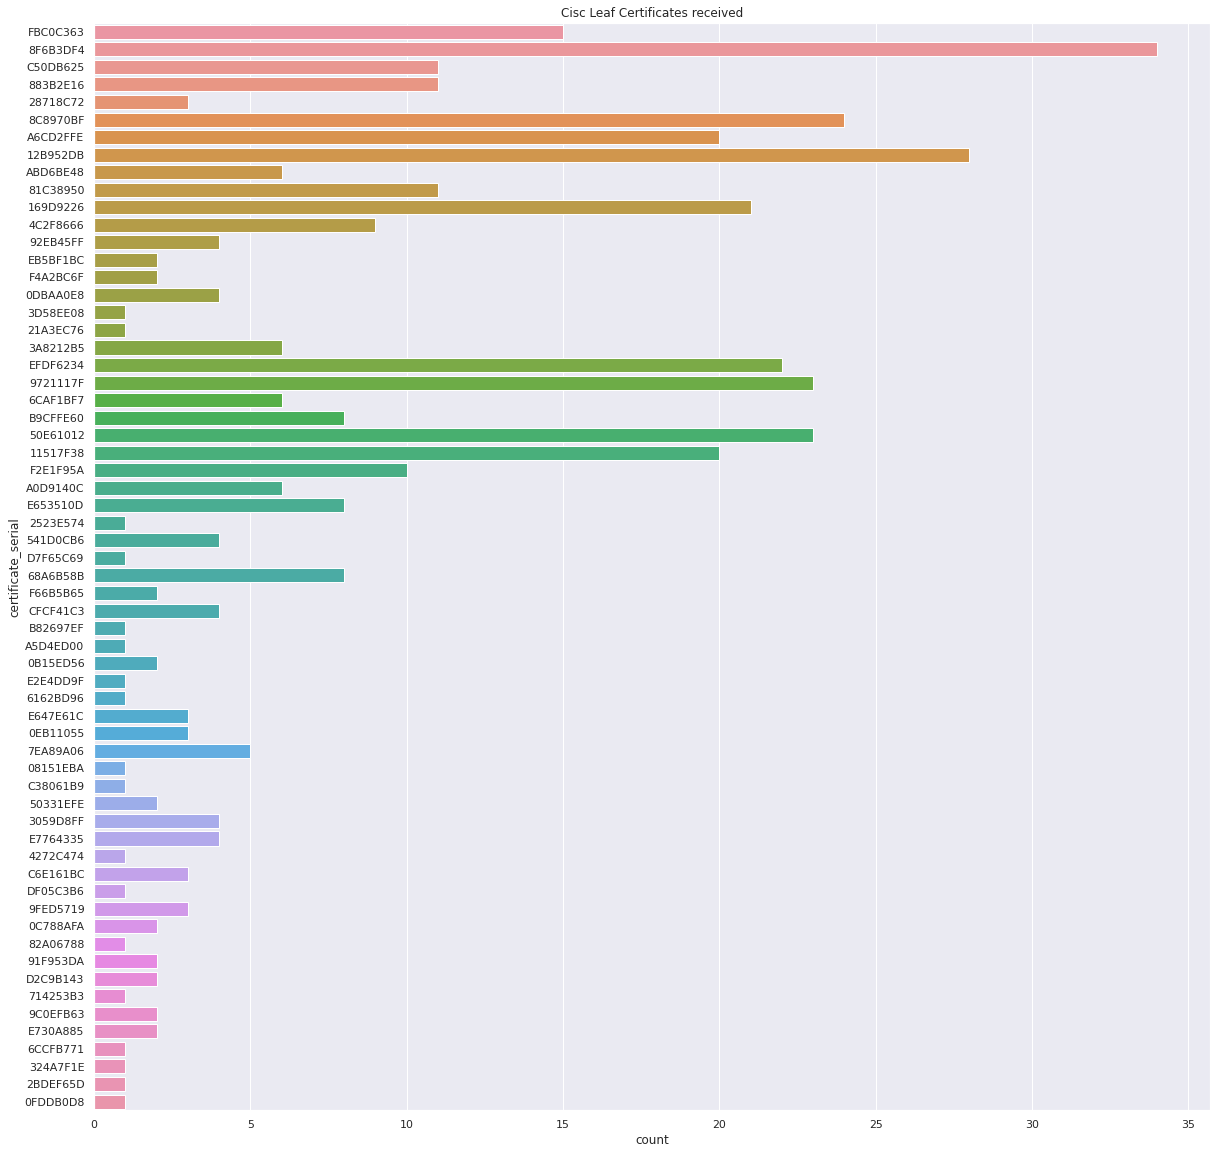

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 20)})
sns.countplot(y="certificate_serial", data=uva_df, orient="h").set(title="Cisc Leaf Certificates received")

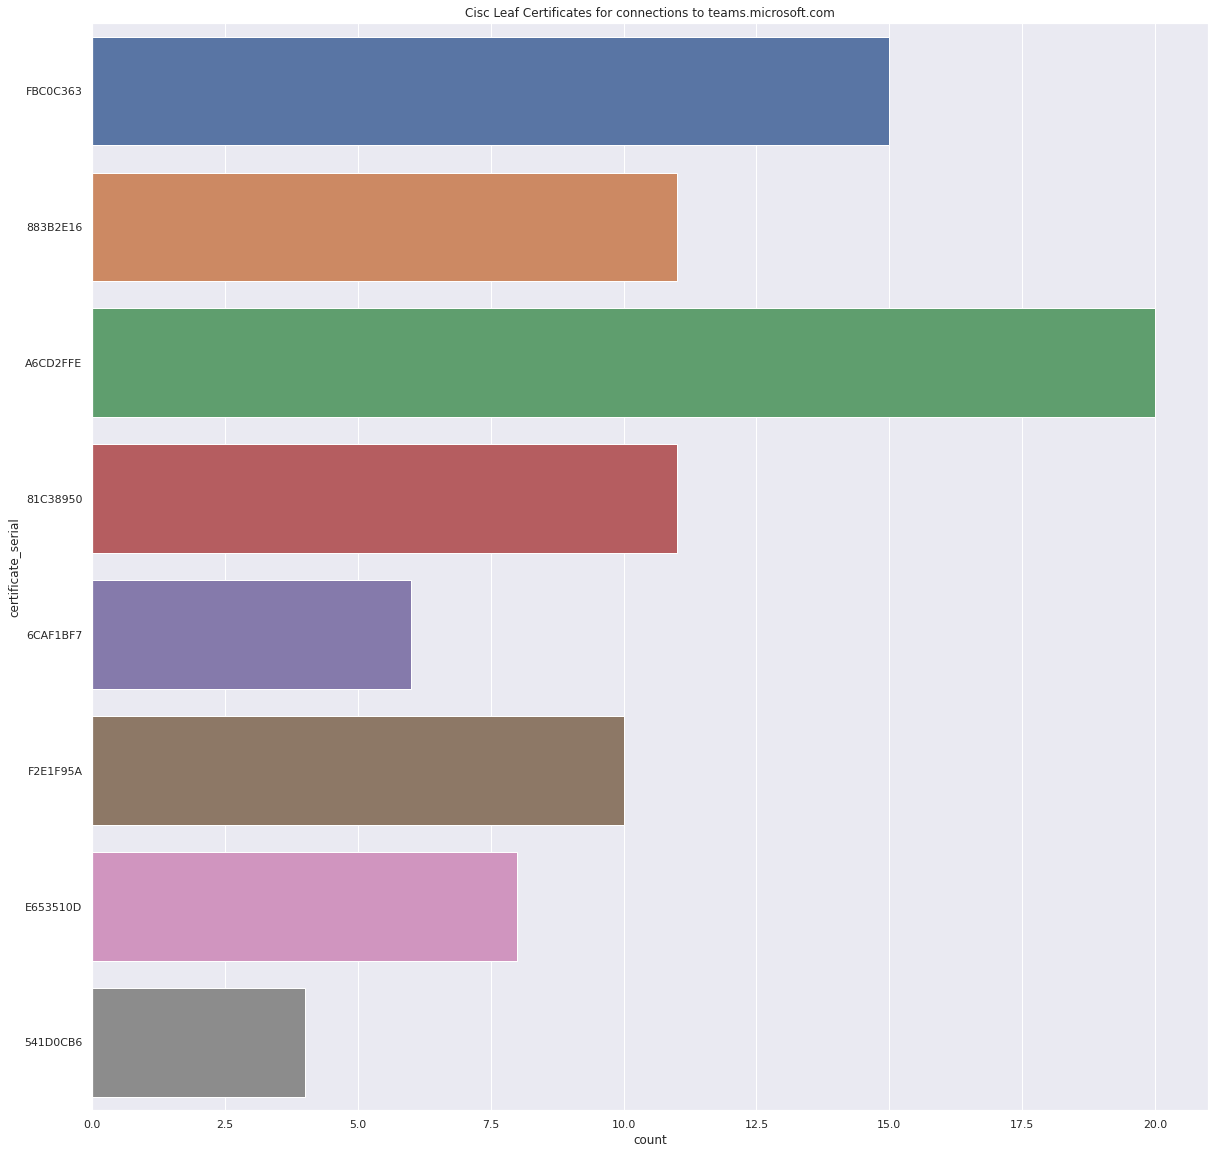

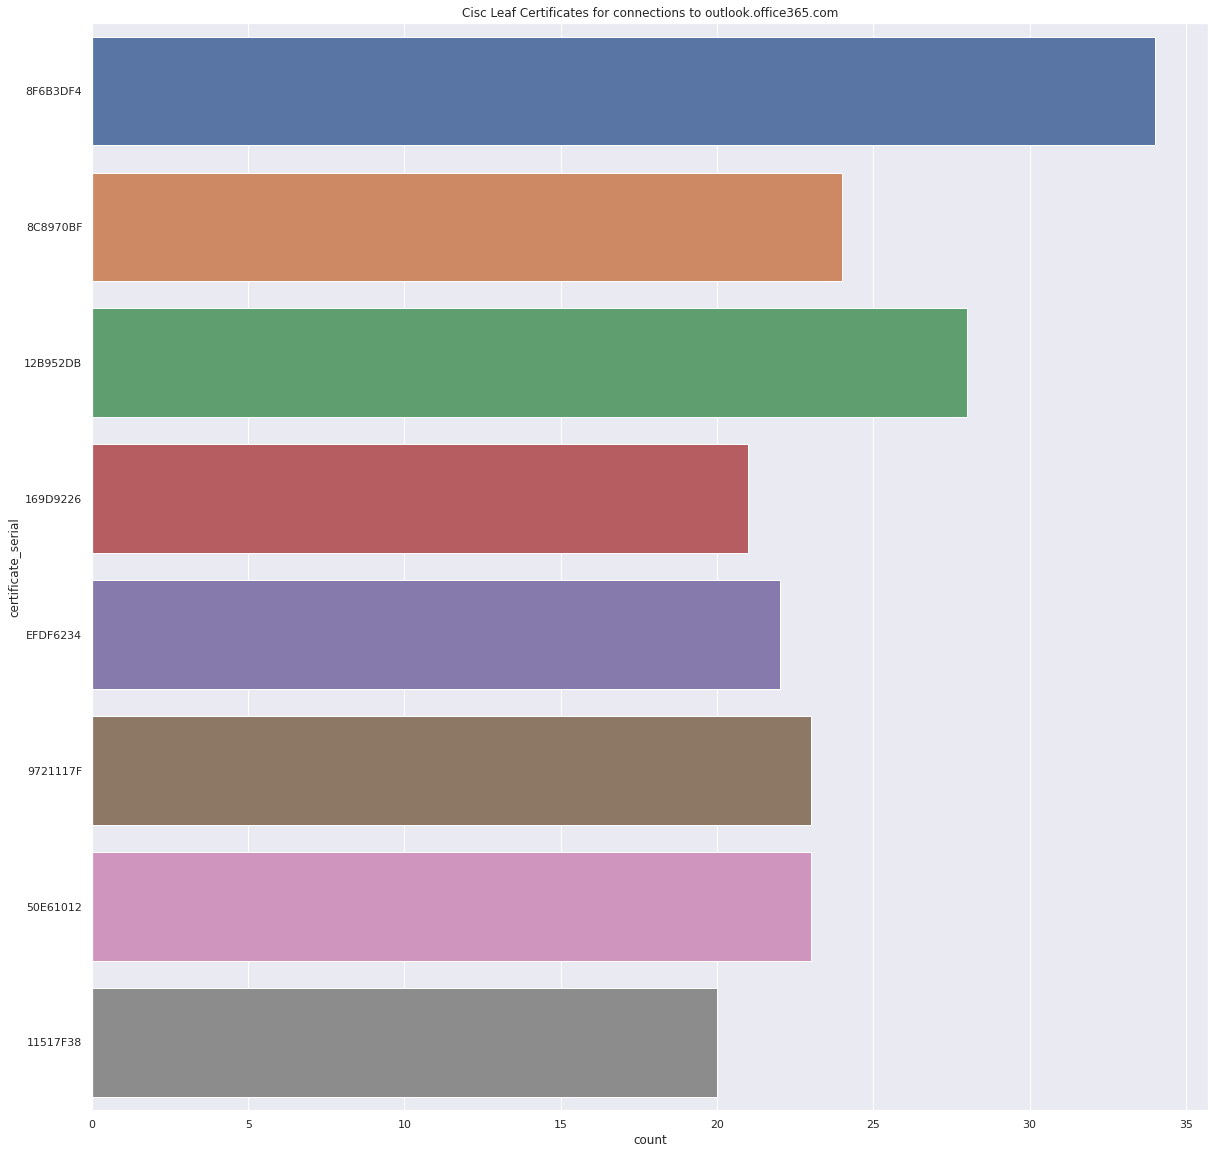

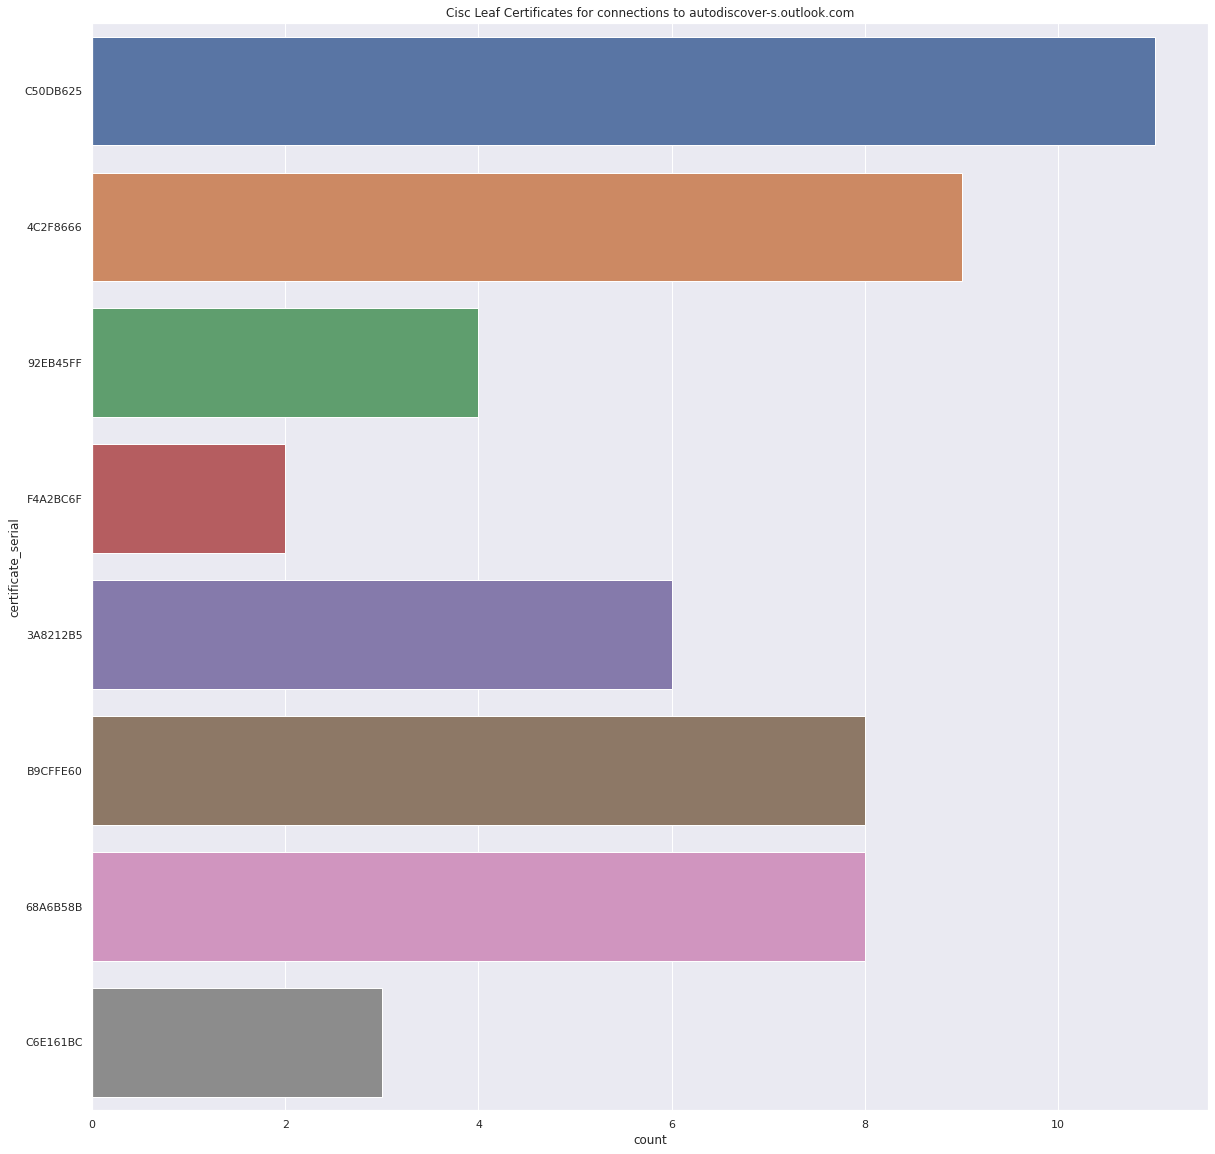

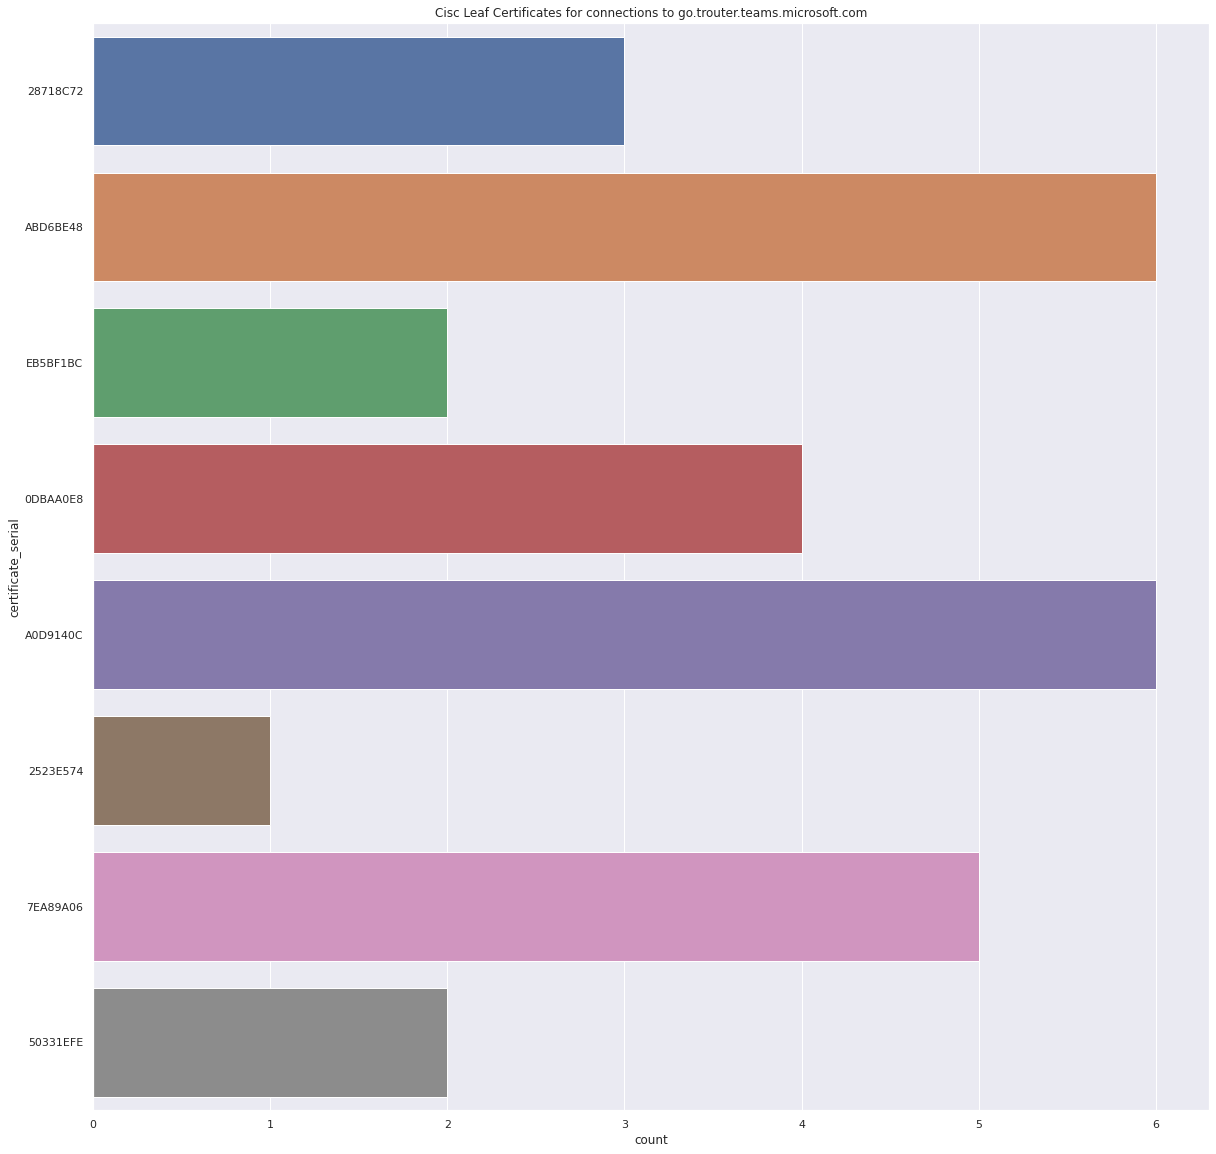

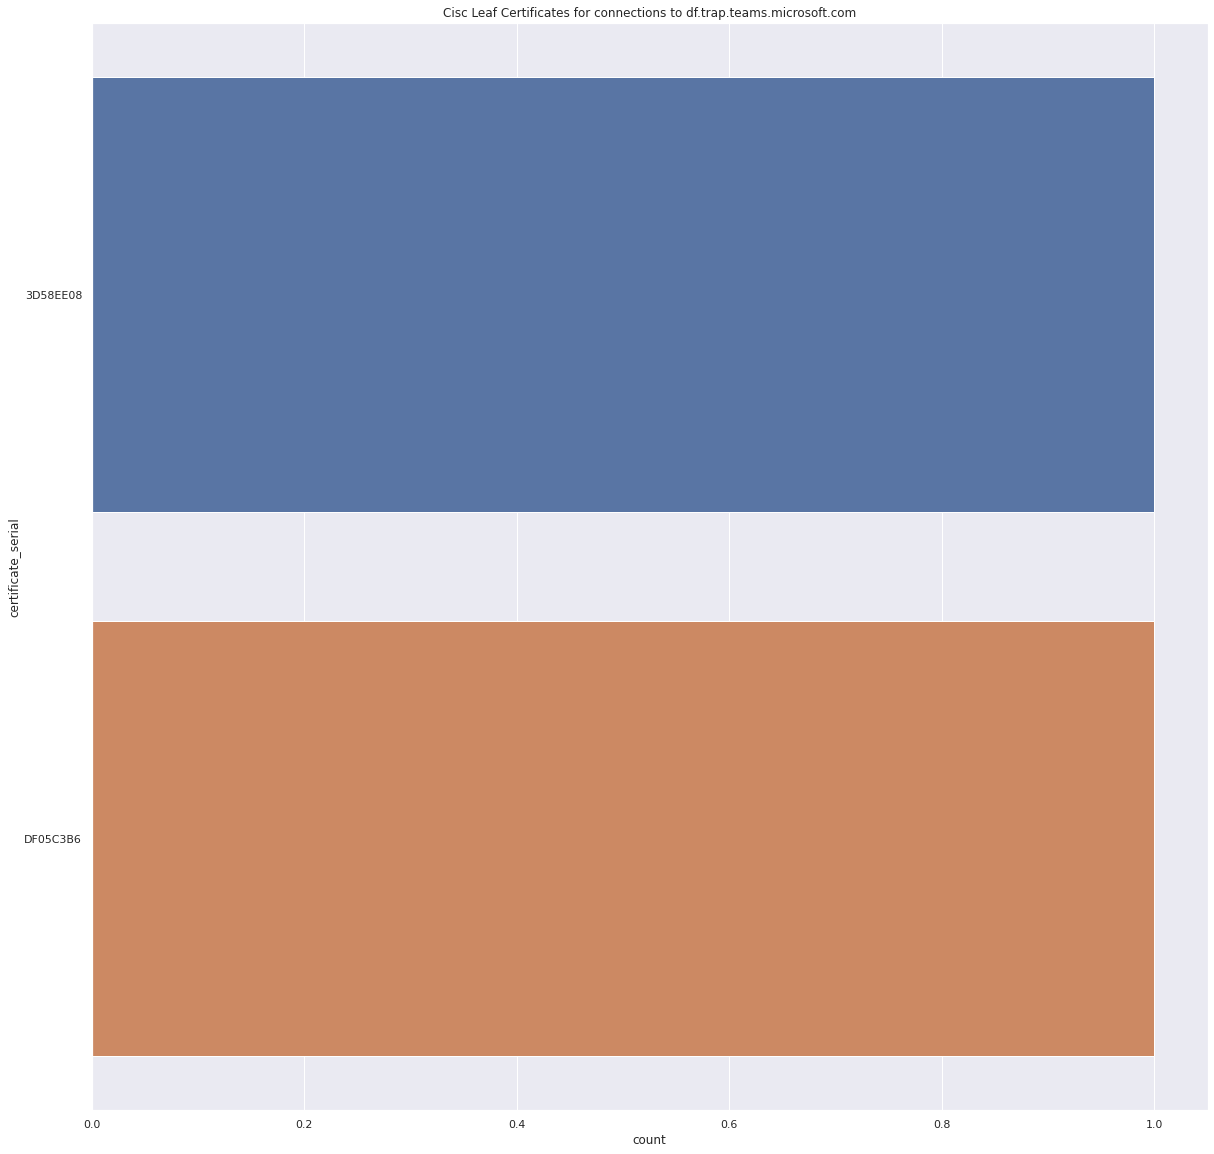

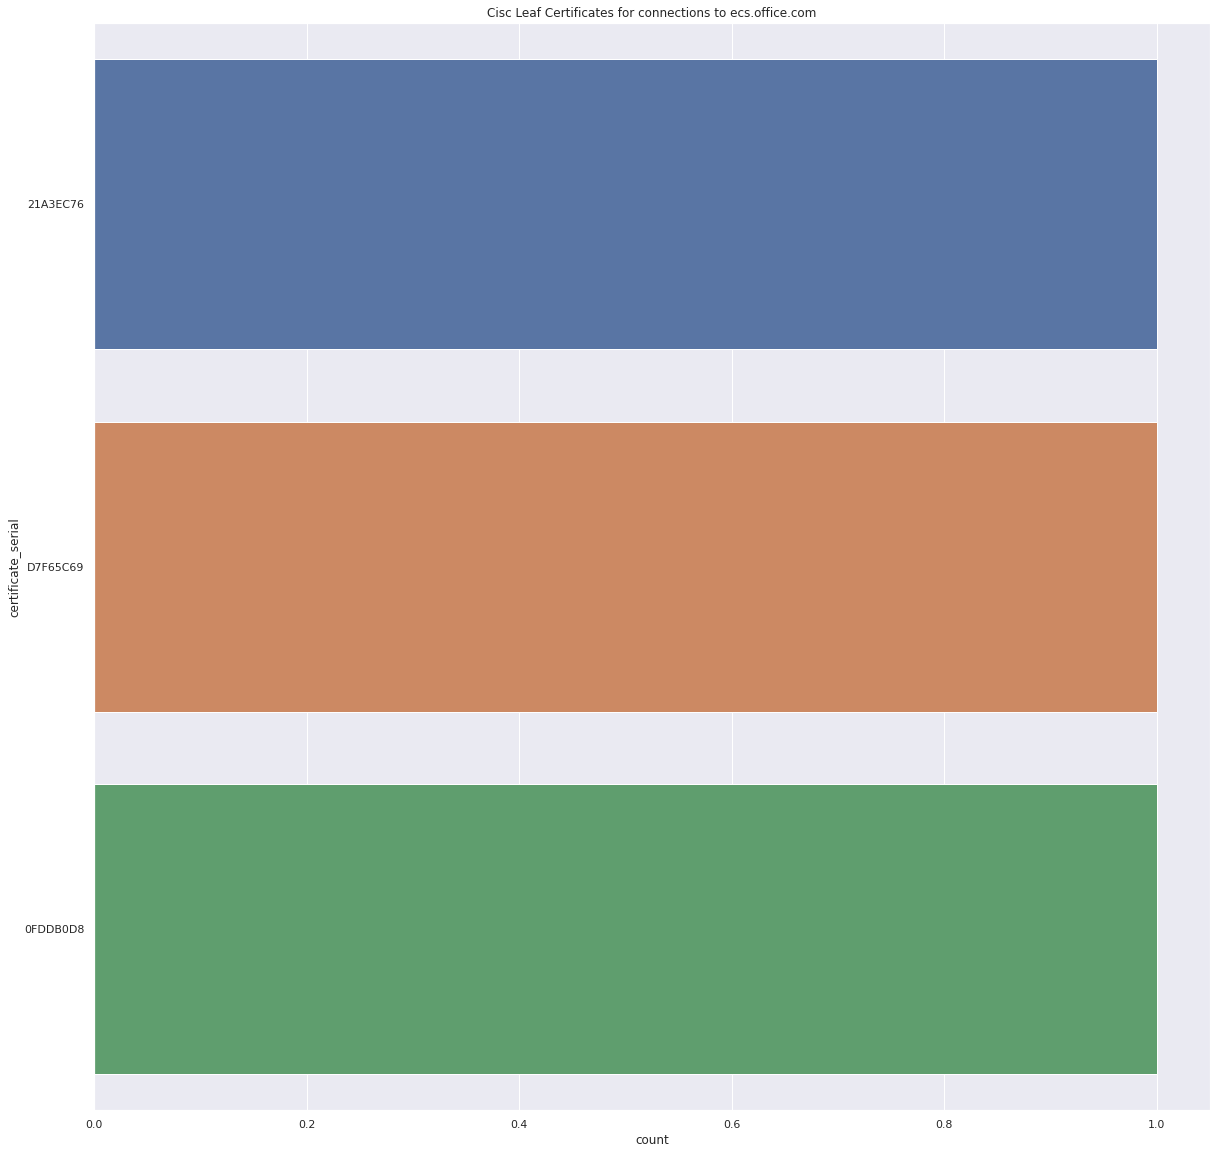

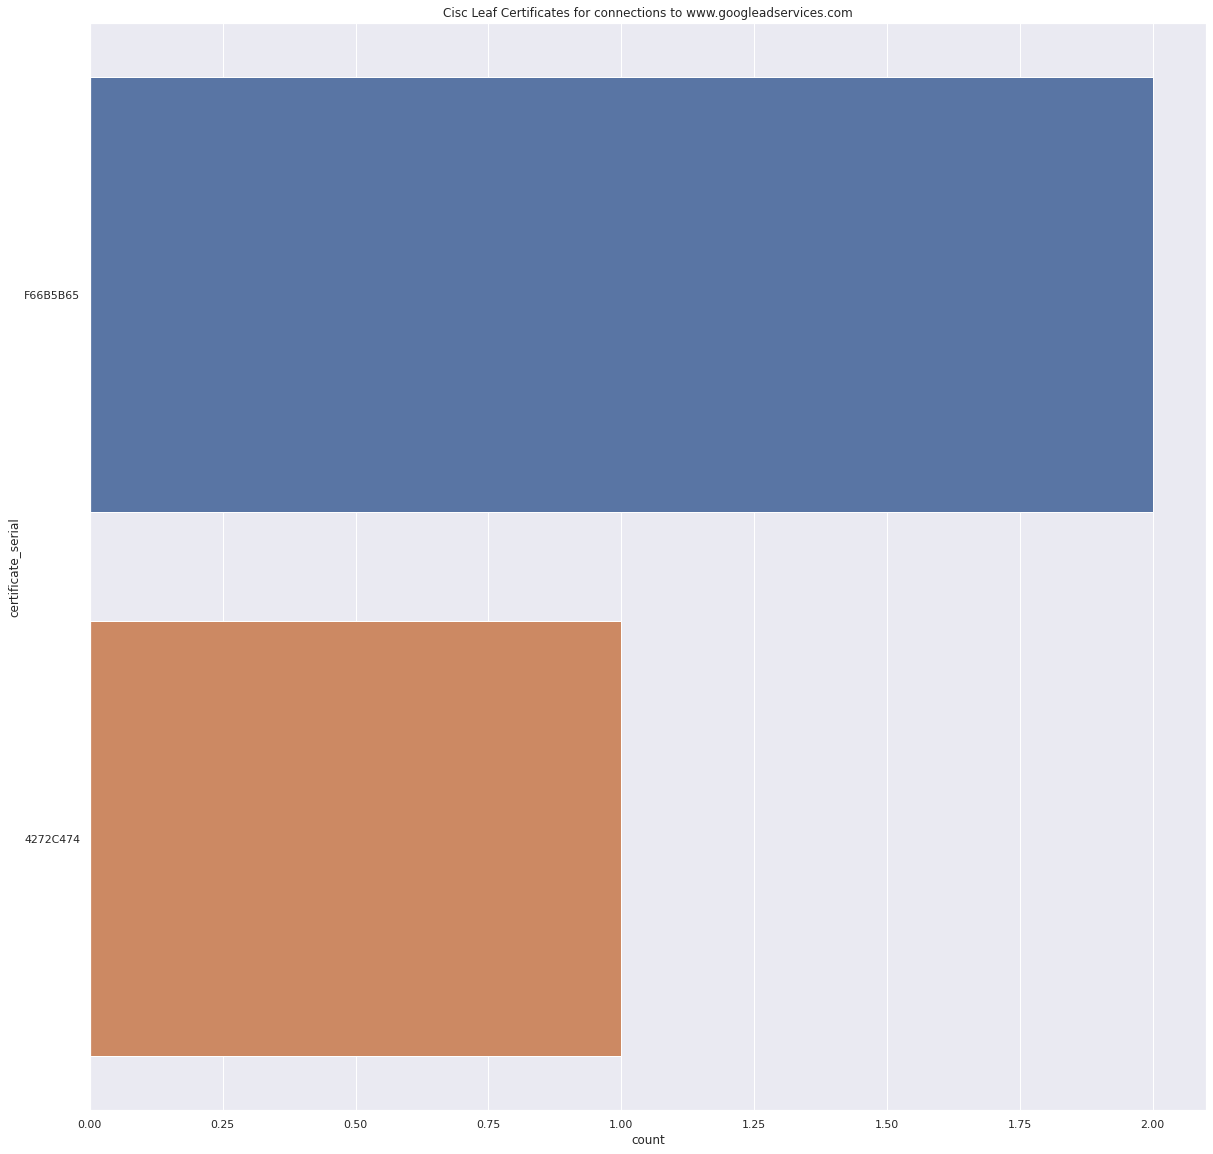

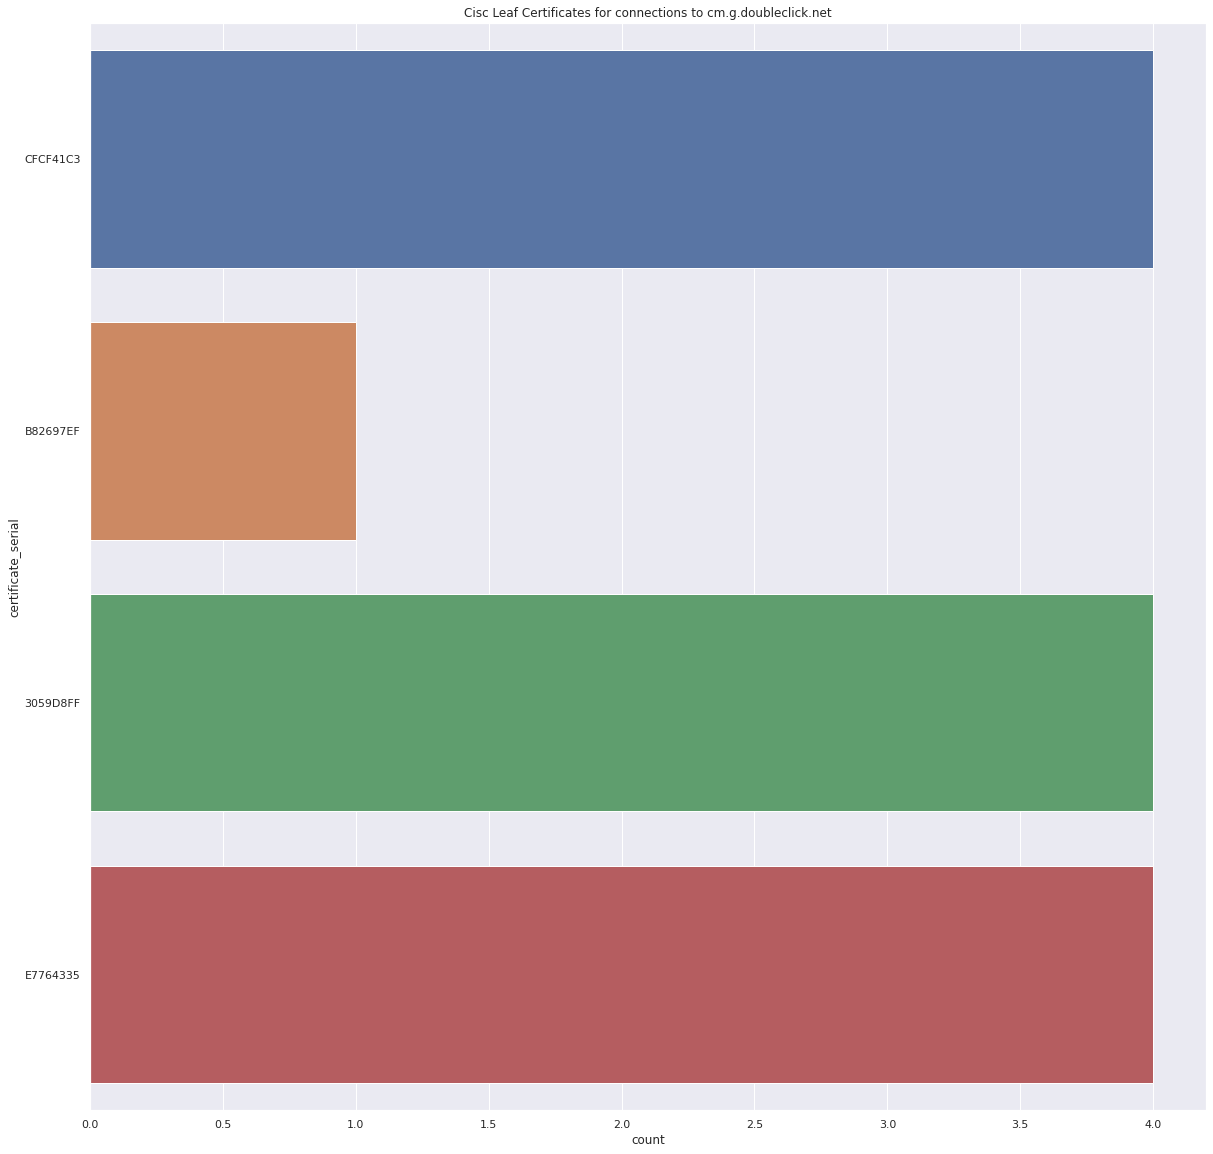

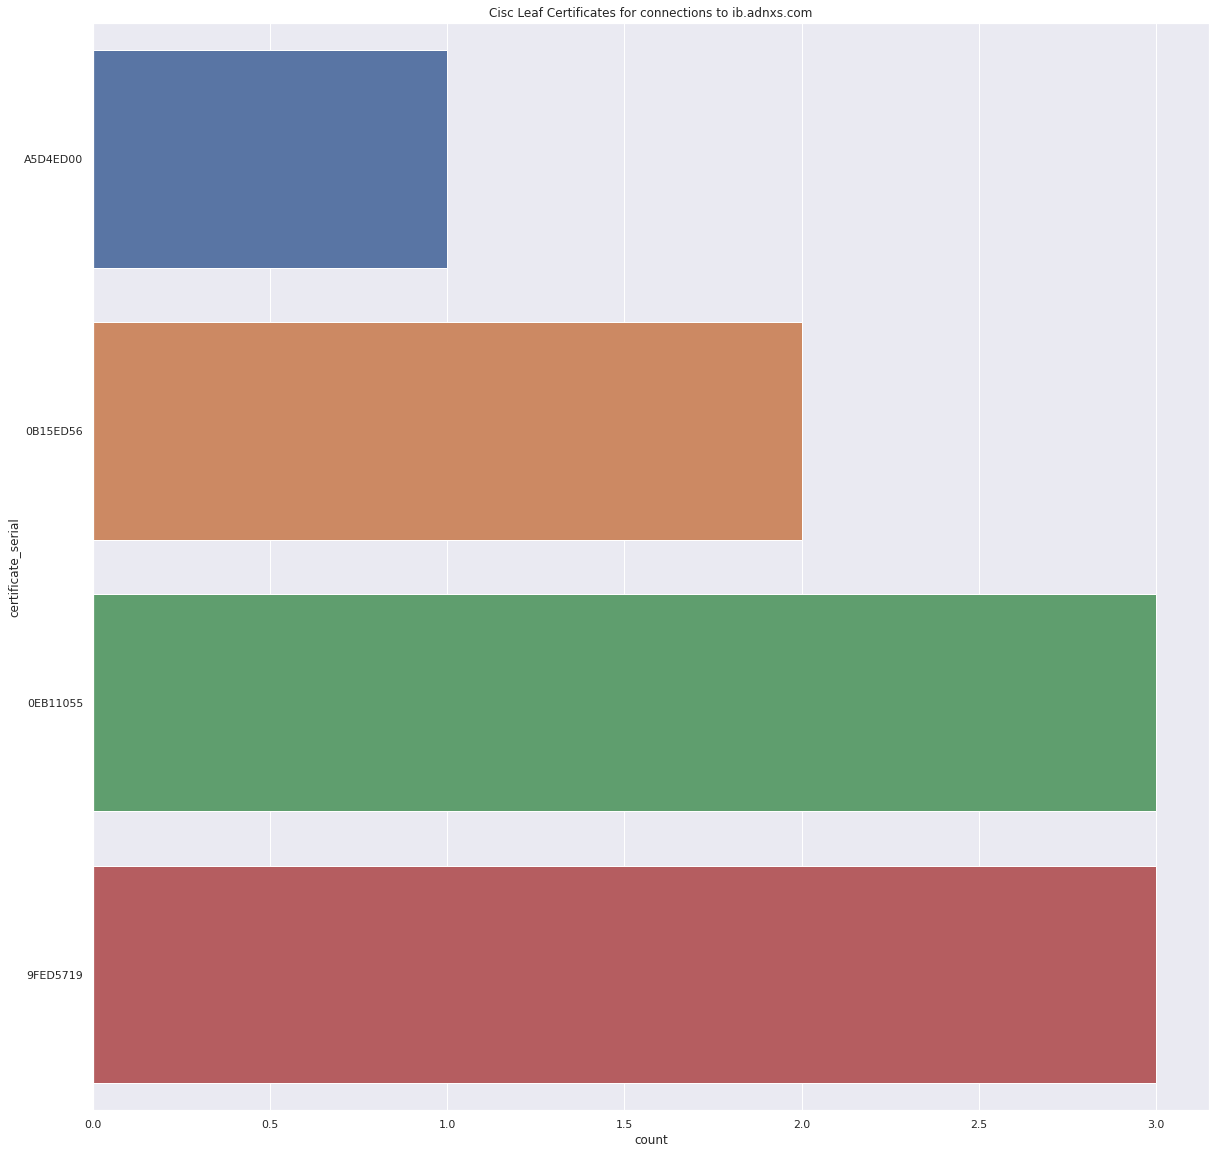

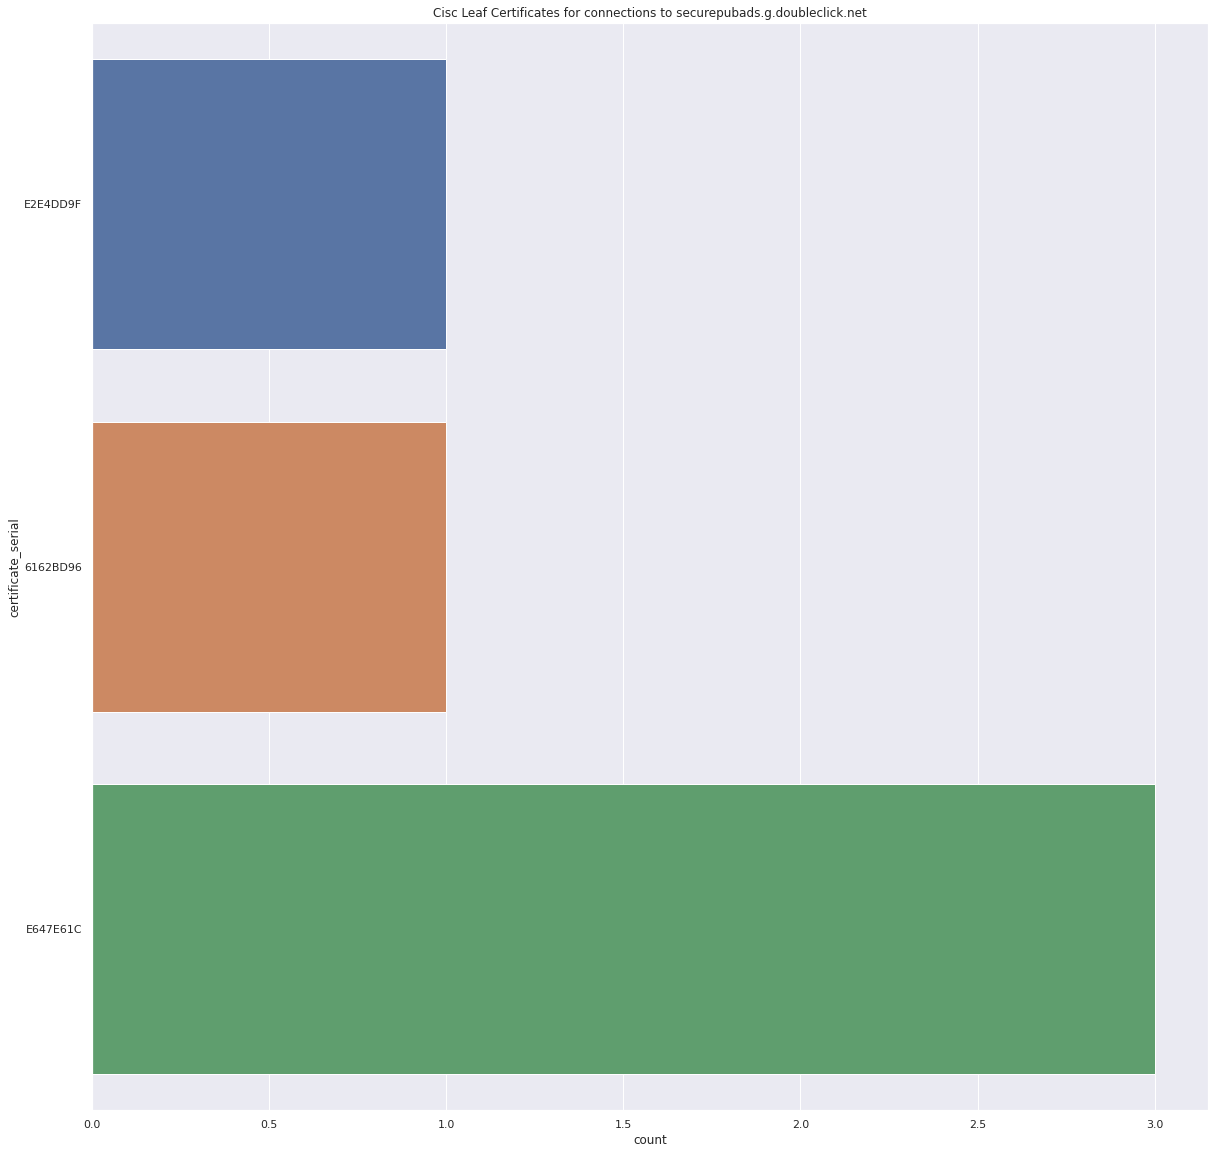

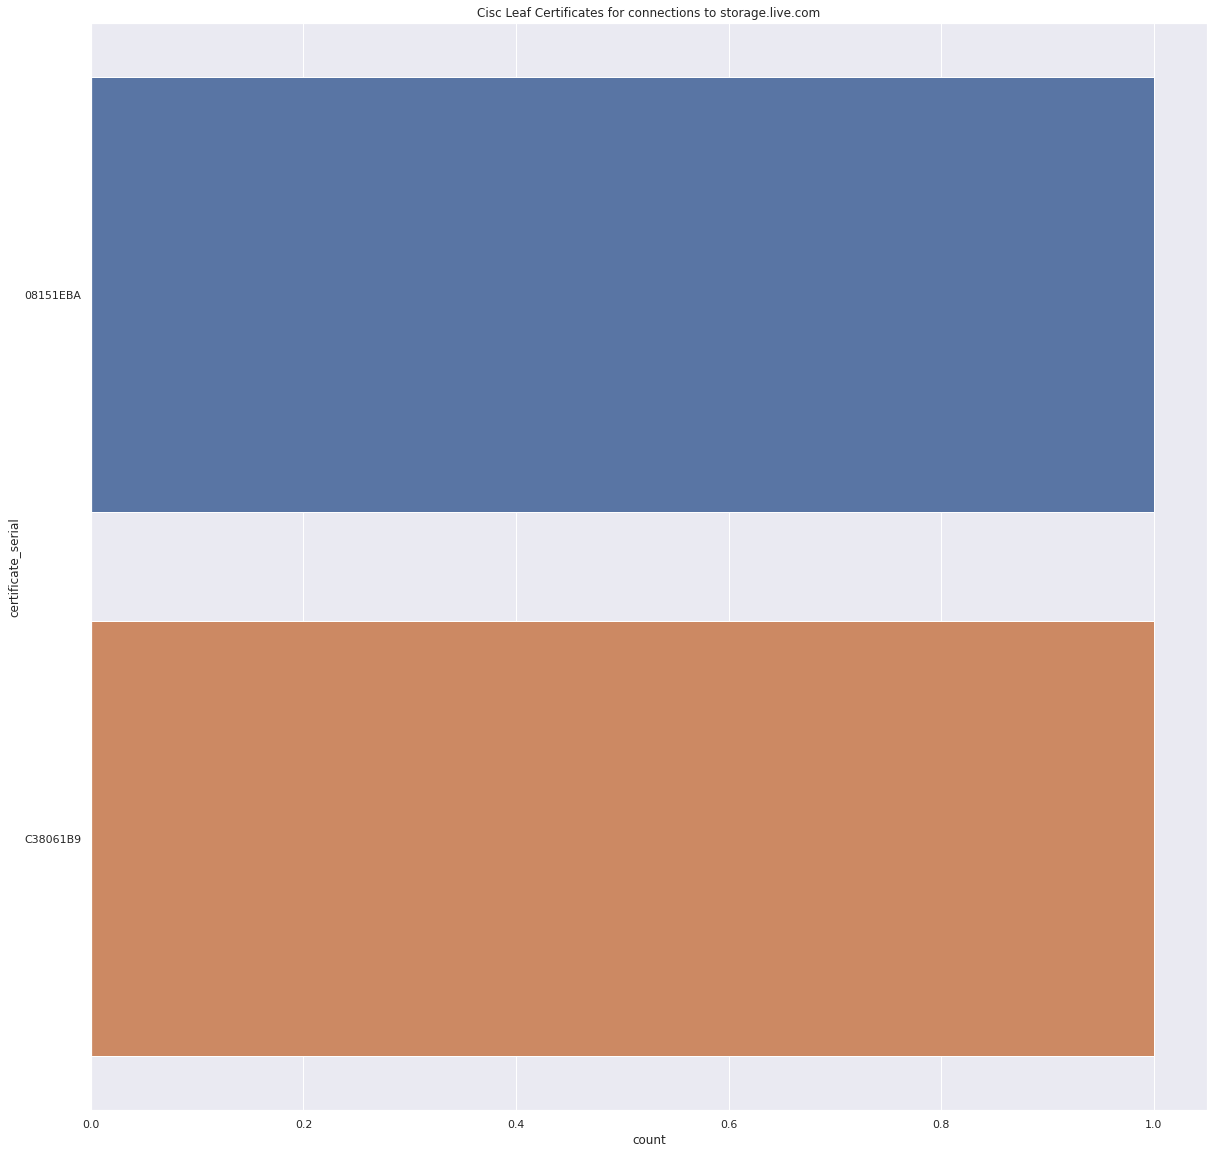

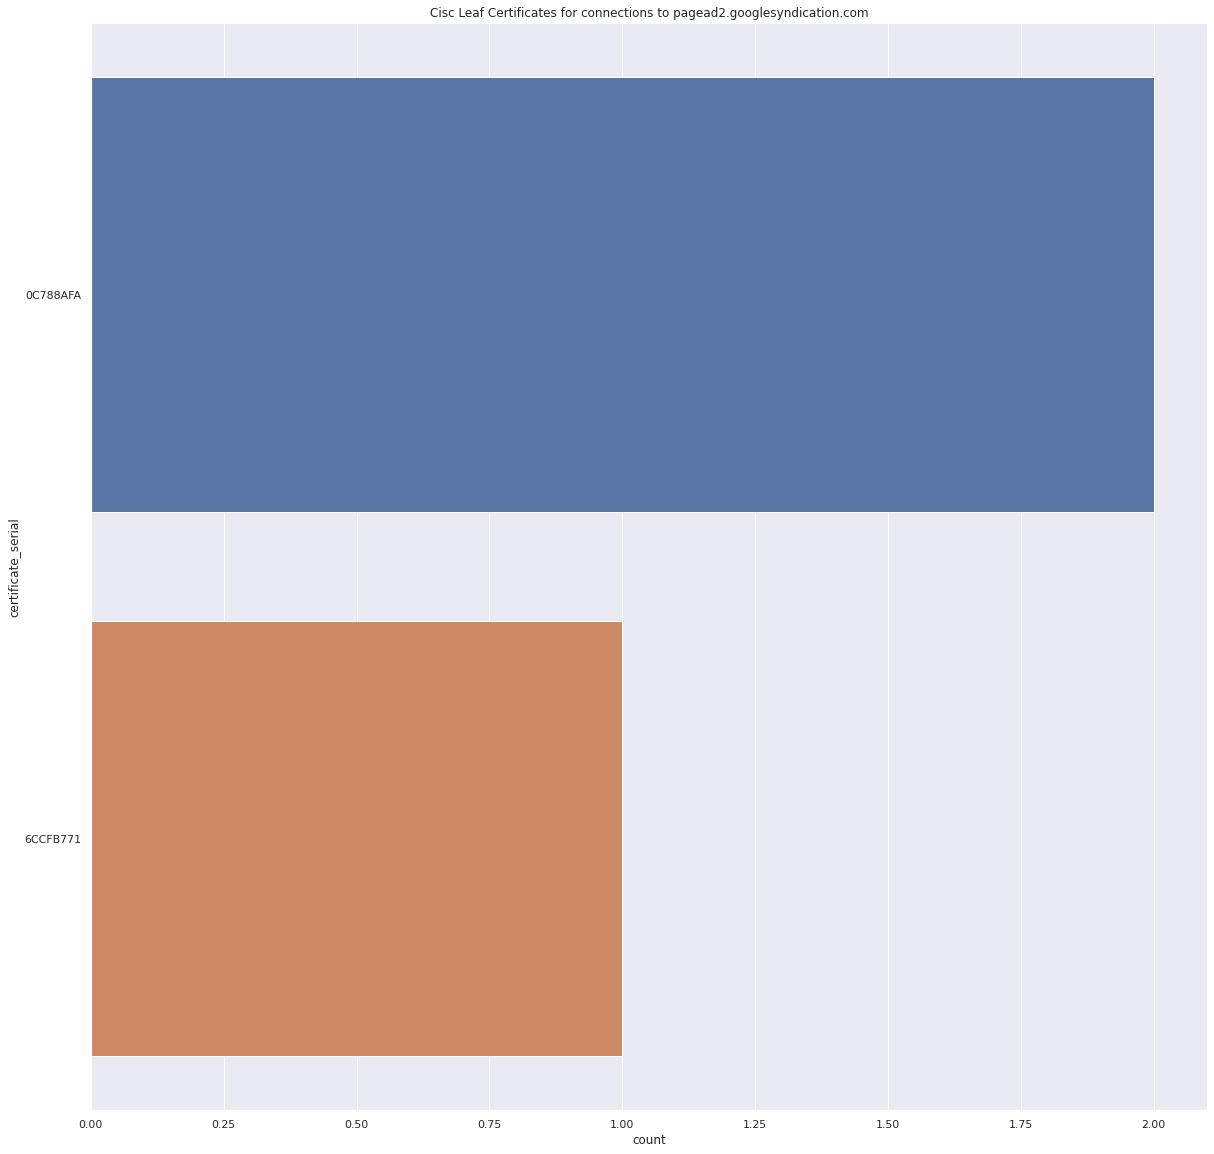

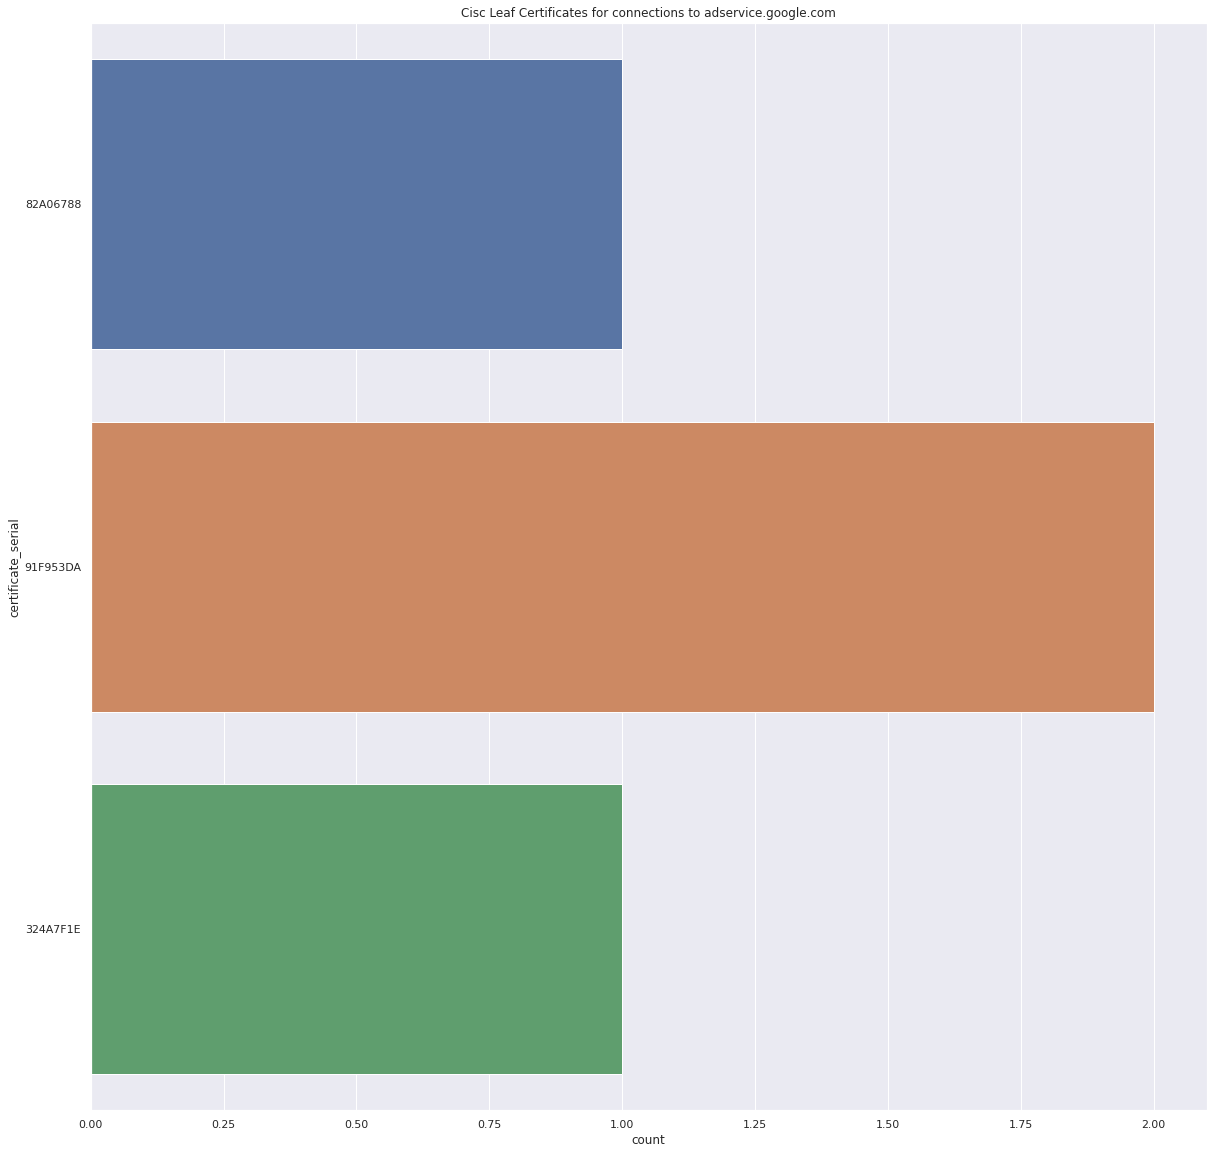

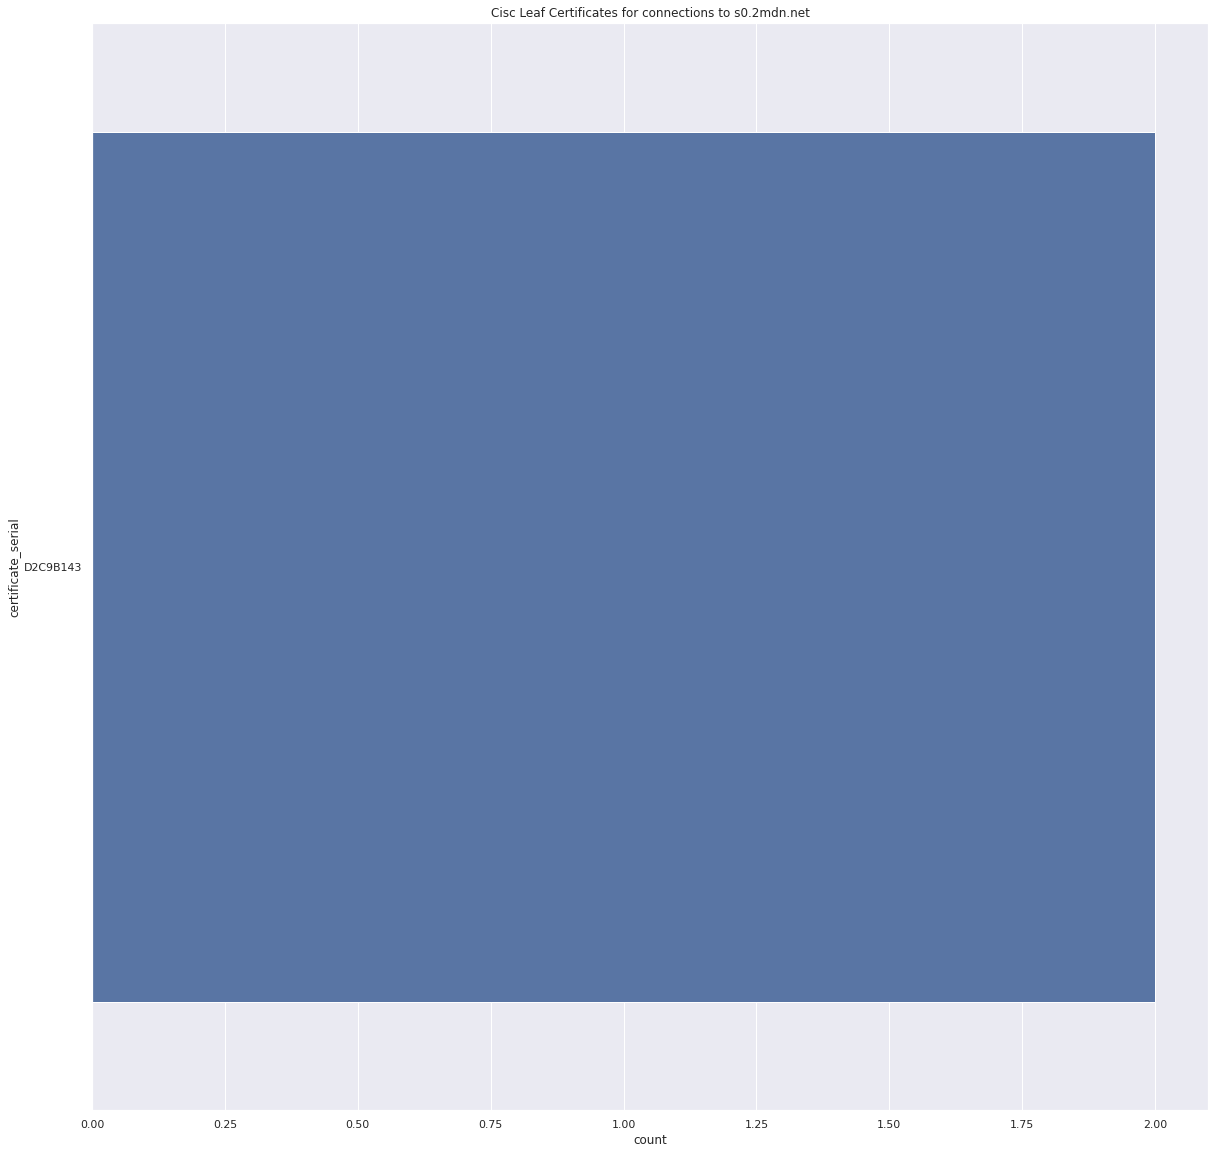

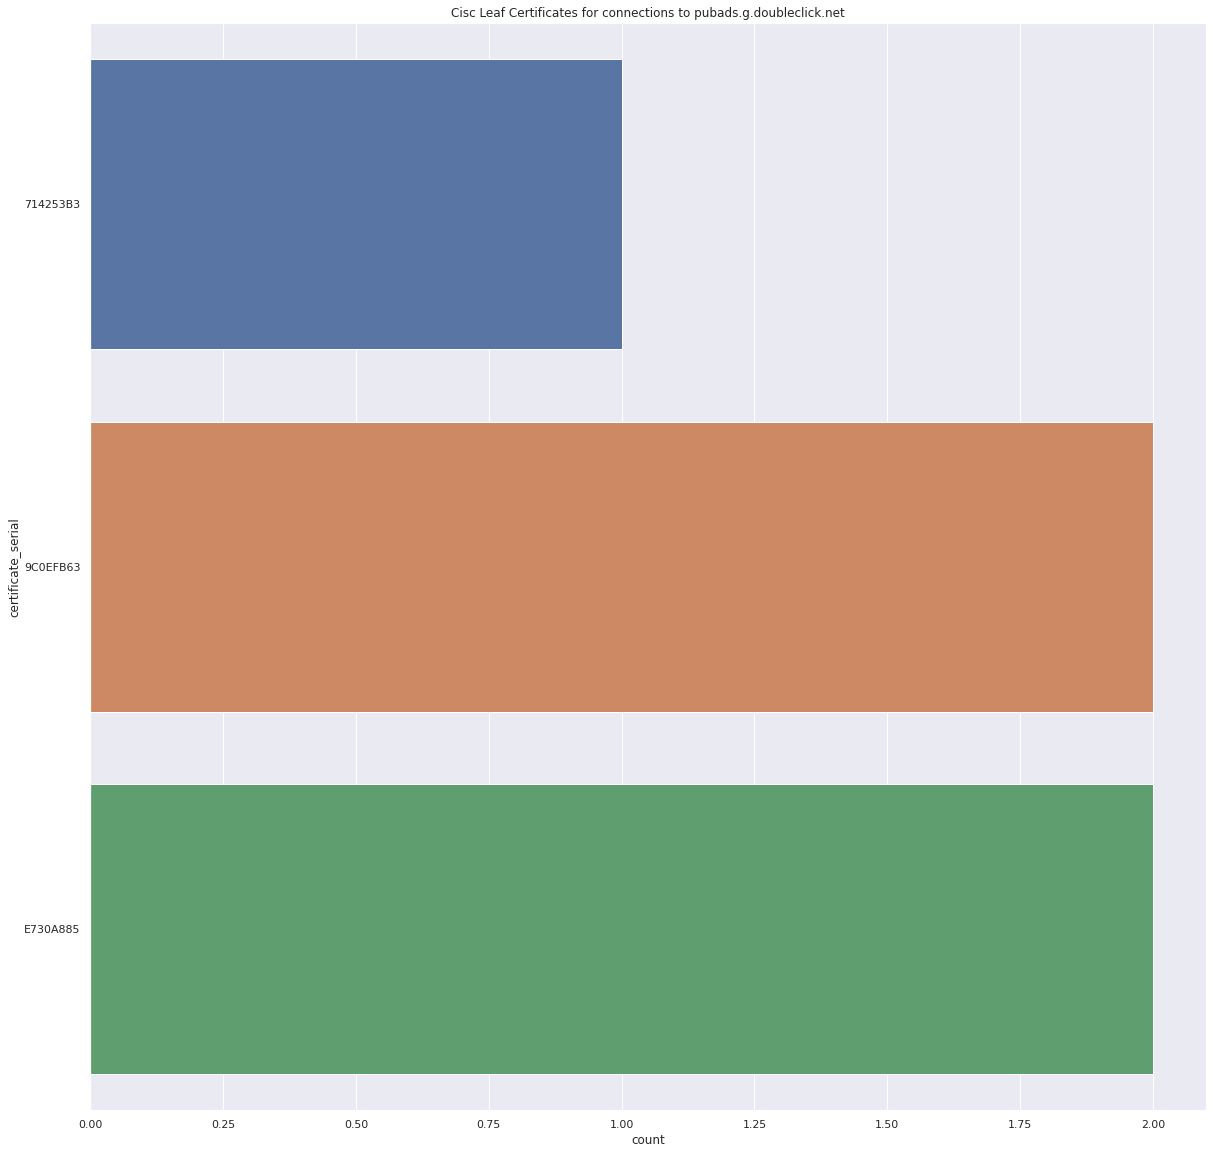

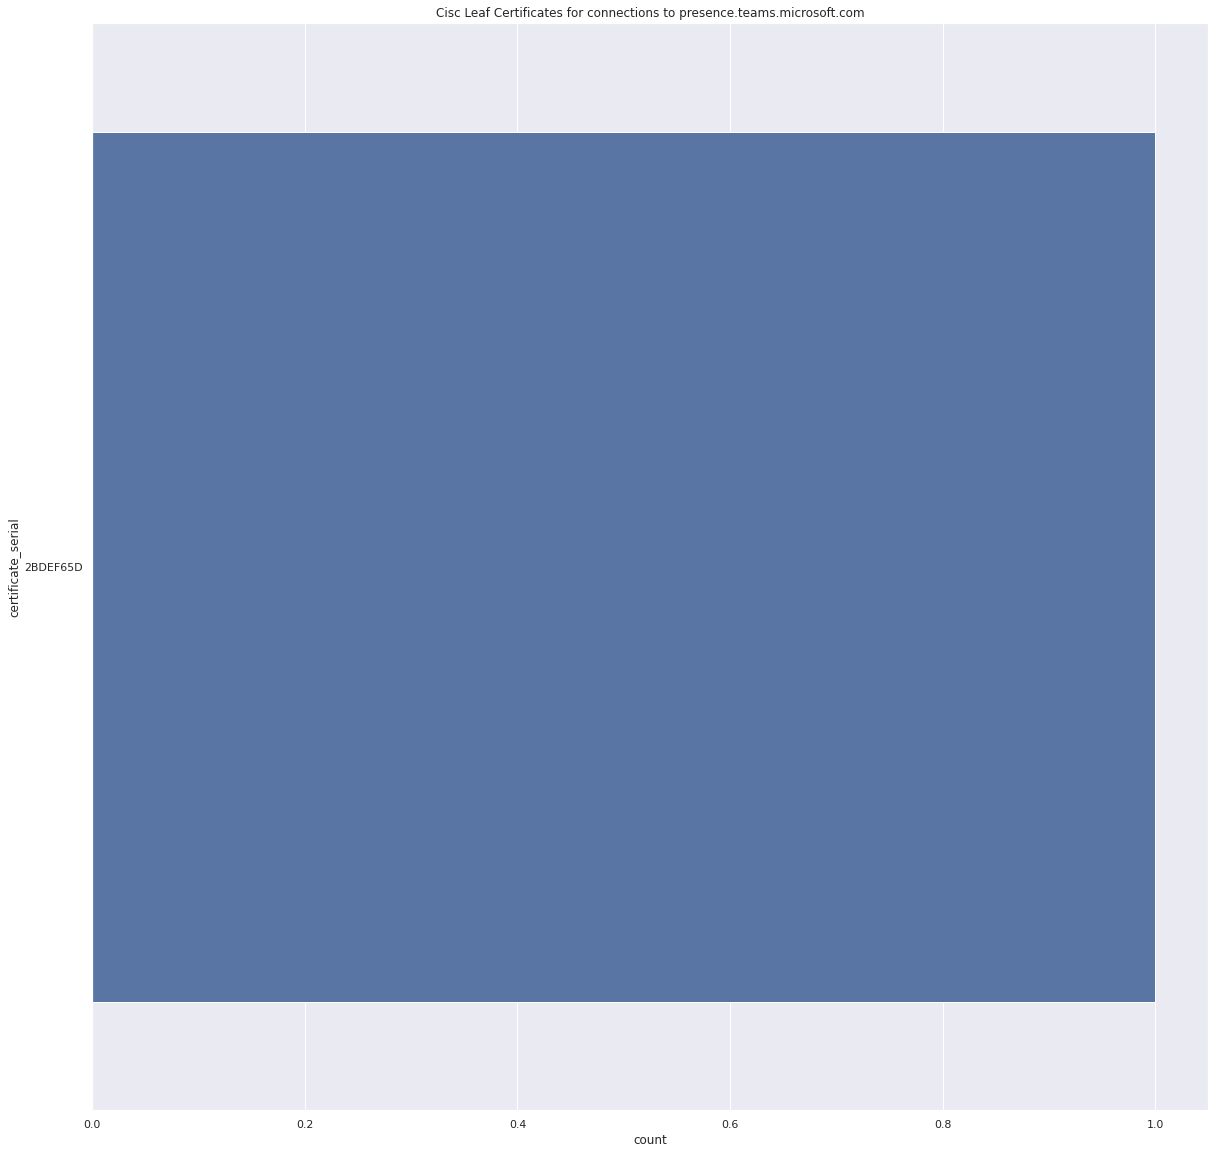

In [24]:
sns.set(rc={'figure.figsize':(20, 20)})
#sns.countplot(data=uva_df, y="domain", hue="certificate_serial")
for domain in uva_df.domain.unique():
    domain_df = uva_df[uva_df["domain"] == domain]
    plt.figure()
    sns.countplot(data=domain_df, y="certificate_serial", orient="h").set(title=f"Cisc Leaf Certificates for connections to {domain}")

In [55]:
#cert_df = uva_df.groupby(["domain"]).count()
#cert_df[["domain", "id_orig_h"]]
cert_df = pd.DataFrame(columns=["certificate_serial", "num_unique_ips"])
for certificate_serial in uva_df.certificate_serial.unique():
    certificate_df = pd.DataFrame(uva_df[uva_df["certificate_serial"] == certificate_serial])
    row = {"certificate_serial": certificate_serial, "num_unique_ips": certificate_df["id_orig_h"].nunique()}
    cert_df.loc[len(cert_df.index)] = row

cert_df
    

    

,certificate_serial,num_unique_ips
0,FBC0C363,1
1,8F6B3DF4,1
2,C50DB625,1
3,883B2E16,1
4,28718C72,1
...,...,...
57,E730A885,1
58,6CCFB771,1
59,324A7F1E,1
60,2BDEF65D,1
